---
---
# Previsão de Customer Churn em Operadoras de Telecom 
---
---

## Engenharia de Atributos // _Feature Engineering_

In [1]:
# Versão da Linguagem Python // Python language version
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Imports
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Versões dos pacotes usados neste jupyter notebook // Versions of packages used in this jupyter notebook
#!pip install -q -U watermark
%reload_ext watermark
%watermark -a "Tatiana Novaes Carvalho" --iversions

Author: Tatiana Novaes Carvalho

pyarrow   : 9.0.0
numpy     : 1.22.3
matplotlib: 3.5.1
joblib    : 1.1.0
pandas    : 1.4.2
seaborn   : 0.11.2



In [4]:
# Parâmetros de configuração dos gráficos // Graph configuration parameters
from matplotlib import rcParams

rcParams['figure.figsize'] = 20, 12
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

### DATASET DE TREINO | _TRAINING DATA SET_

### Carga dos dados // Data load

In [5]:
# Carrega os dados // Load the data
df = pd.read_parquet('../datasets/df_cleaned.dat', engine='pyarrow') # cleaned training dataset

In [6]:
df.shape

(3169, 20)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 1 to 3333
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3169 non-null   object 
 1   account_length                 3169 non-null   int64  
 2   area_code                      3169 non-null   object 
 3   international_plan             3169 non-null   object 
 4   voice_mail_plan                3169 non-null   object 
 5   number_vmail_messages          3169 non-null   int64  
 6   total_day_minutes              3169 non-null   float64
 7   total_day_calls                3169 non-null   int64  
 8   total_day_charge               3169 non-null   float64
 9   total_eve_minutes              3169 non-null   float64
 10  total_eve_calls                3169 non-null   int64  
 11  total_eve_charge               3169 non-null   float64
 12  total_night_minutes            3169 non-null   f

In [8]:
df.head(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,KS,128,area_code_415,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,no
2,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
3,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
4,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
5,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no


In [9]:
df.tail(5)

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
3329,AZ,192,area_code_415,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,no
3330,WV,68,area_code_415,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,no
3331,RI,28,area_code_510,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,no
3332,CT,184,area_code_510,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,no
3333,TN,74,area_code_415,no,yes,25,234.4,113,39.85,265.9,82,22.60,241.4,77,10.86,13.7,4,3.70,0,no


### Separação das Variáveis Categóricas e Numéricas // Separation of Categorical and Numerical Variables

In [10]:
df.columns 

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')

In [11]:
# Lista de colunas categóricas // List of categorical columns
cat_features = ['state',
                'area_code', 
                'international_plan', 
                'voice_mail_plan',
                ]

# Lista de colunas numéricas // List of numerical columns     
num_features = ['account_length', 'number_vmail_messages',
                'total_day_minutes', 'total_day_calls', 'total_day_charge',
                'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
                'total_night_minutes', 'total_night_calls', 'total_night_charge',
                'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
                'number_customer_service_calls',
                ]

# Variável-alvo // Target
target = ['churn']

In [12]:
# Conversão dos tipos de dados das variáveis // Conversion of variables data types

# Categóricas
for feat in cat_features:
    df[feat] = df[feat].astype('category')

# Numéricas
for feat in num_features:
    df[feat] = df[feat].astype('float64')

# Target
df[target] = df[target].astype('category')

In [13]:
# Tipos dos dados de cada variável após conversão // Data types of each variable after conversion
df.dtypes

state                            category
account_length                    float64
area_code                        category
international_plan               category
voice_mail_plan                  category
number_vmail_messages             float64
total_day_minutes                 float64
total_day_calls                   float64
total_day_charge                  float64
total_eve_minutes                 float64
total_eve_calls                   float64
total_eve_charge                  float64
total_night_minutes               float64
total_night_calls                 float64
total_night_charge                float64
total_intl_minutes                float64
total_intl_calls                  float64
total_intl_charge                 float64
number_customer_service_calls     float64
churn                            category
dtype: object

In [14]:
df[cat_features].describe()

,state,area_code,international_plan,voice_mail_plan
count,3169,3169,3169,3169
unique,51,3,2,2
top,WV,area_code_415,no,no
freq,100,1569,2860,2303


In [15]:
df[num_features].describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls
count,3169.000000,3169.000000,3169.000000,3169.00000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000
mean,100.856737,7.974440,180.280120,100.60650,30.648157,201.086904,100.195014,17.092603,200.924361,100.023982,9.041682,10.309340,4.367939,2.784033,1.513411
std,39.474815,13.586481,53.835965,19.72475,9.152086,50.080338,19.614413,4.256827,49.990627,19.405317,2.249643,2.665854,2.156224,0.719748,1.215649
min,1.000000,0.000000,17.600000,42.00000,2.990000,49.200000,42.000000,4.180000,50.100000,42.000000,2.250000,2.000000,1.000000,0.540000,0.000000
25%,74.000000,0.000000,144.000000,87.00000,24.480000,166.800000,87.000000,14.180000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,100.000000,0.000000,179.900000,101.00000,30.580000,201.400000,100.000000,17.120000,201.100000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,19.000000,217.000000,114.00000,36.890000,235.100000,114.000000,19.980000,235.600000,113.000000,10.600000,12.100000,6.000000,3.270000,2.000000
max,217.000000,49.000000,337.400000,160.00000,57.360000,351.600000,159.000000,29.890000,352.500000,158.000000,15.860000,18.400000,11.000000,4.970000,5.000000


### Extração de Recursos // Feature Extraction

In [16]:
# Funçõo para geração de distplot
def plot_distplot(df, features_list:list, qtd_subplots:int=3, color:str='darkblue', orient:str='v'):
    """
    Função para análise univariada das variáveis numéricas utilizando gráficos distplots da biblioteca Seaborn.
    Function for univariate analysis of numerical variables using distplot plots from the Seaborn library.
    """
    plt.figure(figsize = (20, 15))
    for i in range(0, len(features_list)):
        plt.subplot(qtd_subplots, int(len(features_list)/qtd_subplots), i+1)
        chart = sns.histplot(x = df[features_list[i]], kde = True, color = color)
        plt.xlabel(features_list[i])
        plt.tight_layout()
    
    return chart

# Funçõo para geração de distplot com log da variável
def plot_distplot_log(df, features_list:list, qtd_subplots:int=3, color:str='darkblue', orient:str='v'):
    """
    Função para análise univariada das variáveis numéricas utilizando log e gráficos distplots da biblioteca Seaborn.
    Function for univariate analysis of numerical variables using log and distplot plots from the Seaborn library.
    """
    #plt.figure(figsize = (15,12))
    for i in range(0, len(features_list)):
        plt.figure(figsize = (6, 4))
        chart = sns.histplot(x = np.log(df[features_list[i]]), kde = True, color = color)
        plt.xlabel(features_list[i])
        plt.tight_layout()
    
    return chart


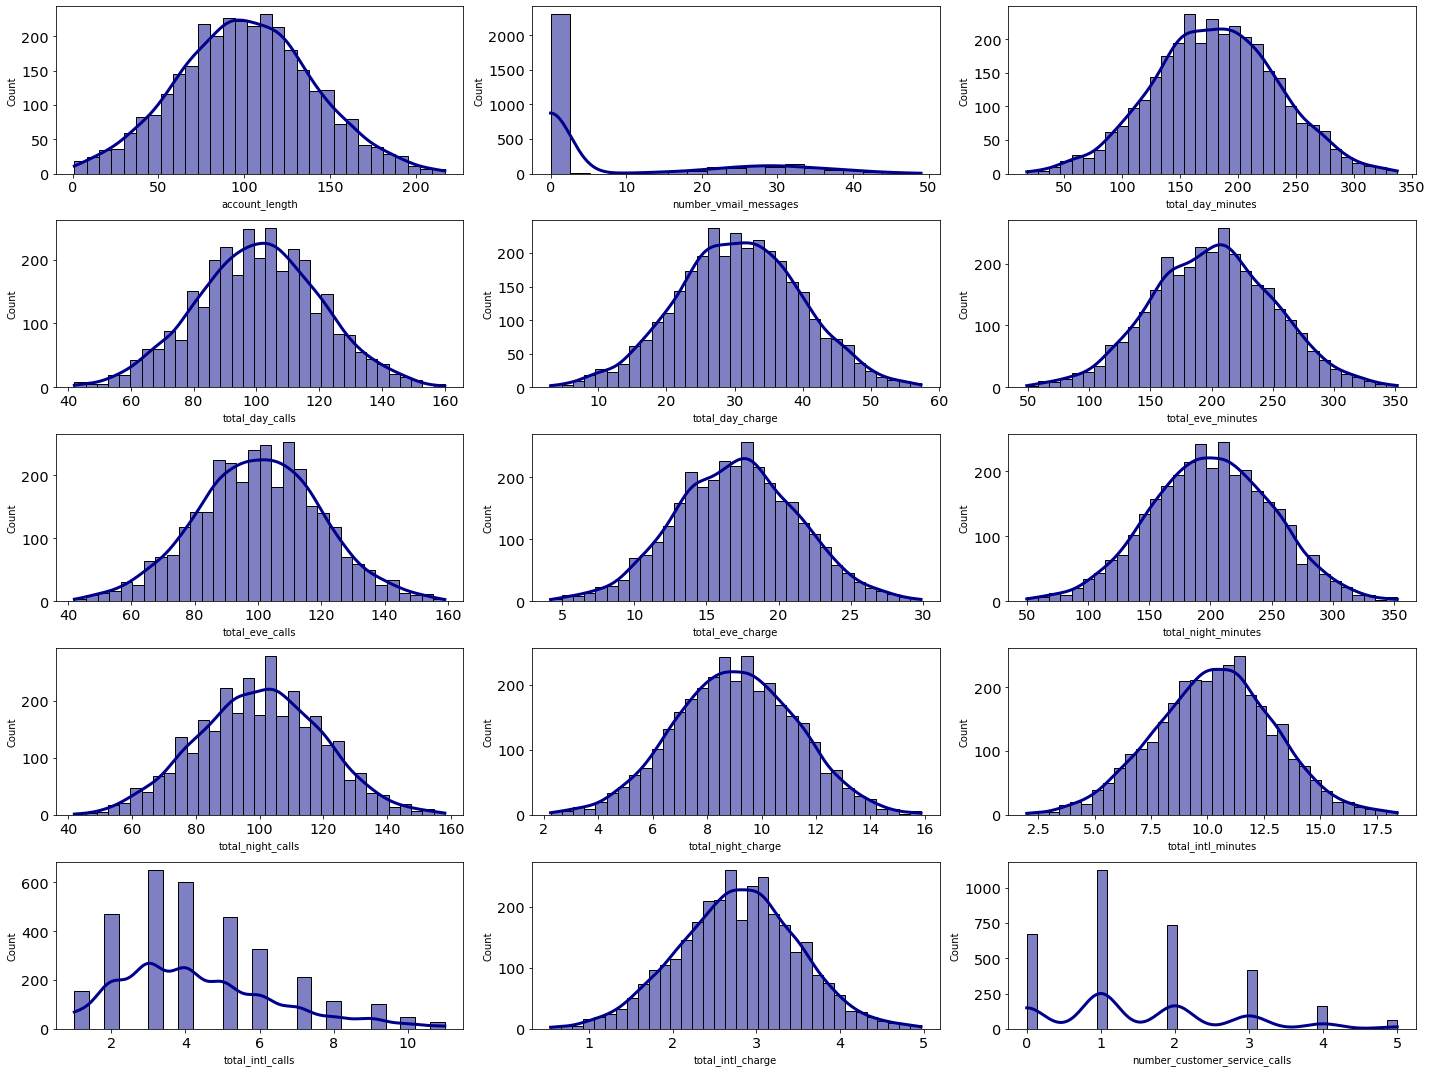

In [17]:
# Distplots das variáveis numéricas // Distplots of numeric variables

# Chamada à função
plot_distplot(df=df, features_list=num_features,qtd_subplots=5);

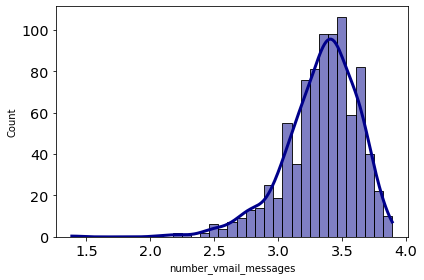

In [18]:
# Distplot (log) da variável number_vmail_messages // Distplot (log) of variable number_vmail_messages

# Chamada à função
issue_feat = ['number_vmail_messages']
plot_distplot_log(df=df, features_list=issue_feat, qtd_subplots=3);

In [19]:
# Checando os valores de maior frequência da variável number_vmail_messages
# Checking the most frequent values of the number_vmail_messages variable

print(df[['number_vmail_messages', 'churn']].value_counts().head(10))
print()
print(df[df['churn']=='yes']['number_vmail_messages'].value_counts().head(10))

number_vmail_messages  churn
0.0                    no       1930
                       yes       373
31.0                   no         53
29.0                   no         44
28.0                   no         42
30.0                   no         40
27.0                   no         38
24.0                   no         38
25.0                   no         37
33.0                   no         36
dtype: int64

0.0     373
33.0      6
26.0      6
29.0      6
28.0      6
32.0      5
35.0      4
31.0      3
42.0      3
27.0      3
Name: number_vmail_messages, dtype: int64


**Observações:**
1. A variável number_vmail_messages apresenta alta frequência de valores baixos. Como a aplicação do logaritmo aos valores desse atributo resultou em uma distribuição similar à de uma normal para valores acima de 2.5, embora com distribuição assimétrica à esquerda. Assim, esse atributo será mantido no conjunto de dados para aprofundamento da análise.
2. Considerando que a variável number_customer_service_calls parece não seguir uma distribuição normal (comportamento de uma distribuição uniforme), essa variável será excluída do dataset.
3. A variável total_intl_calls, embora com distribuição assimétrica à direita, será mantida no conjunto de dados para aprofundamento da análise.
---

**Observations:**
1. _The variable number_vmail_messages has a high frequency of low values. As the application of the logarithm to the values of this attribute resulted in a distribution similar to a normal one for values above 2.5, although with a skewed distribution to the left. Thus, this attribute will be kept in the dataset for further analysis._
2. _Since the number_customer_service_calls variable appears not to follow a normal distribution (behavior of a uniform distribution), this variable will be excluded from the dataset._
3. _The variable total_intl_calls, although with right-skewed distribution, will be kept in the dataset for further analysis._

In [20]:
# Exclusão da variável number_customer_service_calls (distribuição uniforme)
# Removing the number_customer_service_calls variable (even distribution)

df = df.drop(columns = ['number_customer_service_calls'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 1 to 3333
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   state                  3169 non-null   category
 1   account_length         3169 non-null   float64 
 2   area_code              3169 non-null   category
 3   international_plan     3169 non-null   category
 4   voice_mail_plan        3169 non-null   category
 5   number_vmail_messages  3169 non-null   float64 
 6   total_day_minutes      3169 non-null   float64 
 7   total_day_calls        3169 non-null   float64 
 8   total_day_charge       3169 non-null   float64 
 9   total_eve_minutes      3169 non-null   float64 
 10  total_eve_calls        3169 non-null   float64 
 11  total_eve_charge       3169 non-null   float64 
 12  total_night_minutes    3169 non-null   float64 
 13  total_night_calls      3169 non-null   float64 
 14  total_night_charge     3169 non-null   f

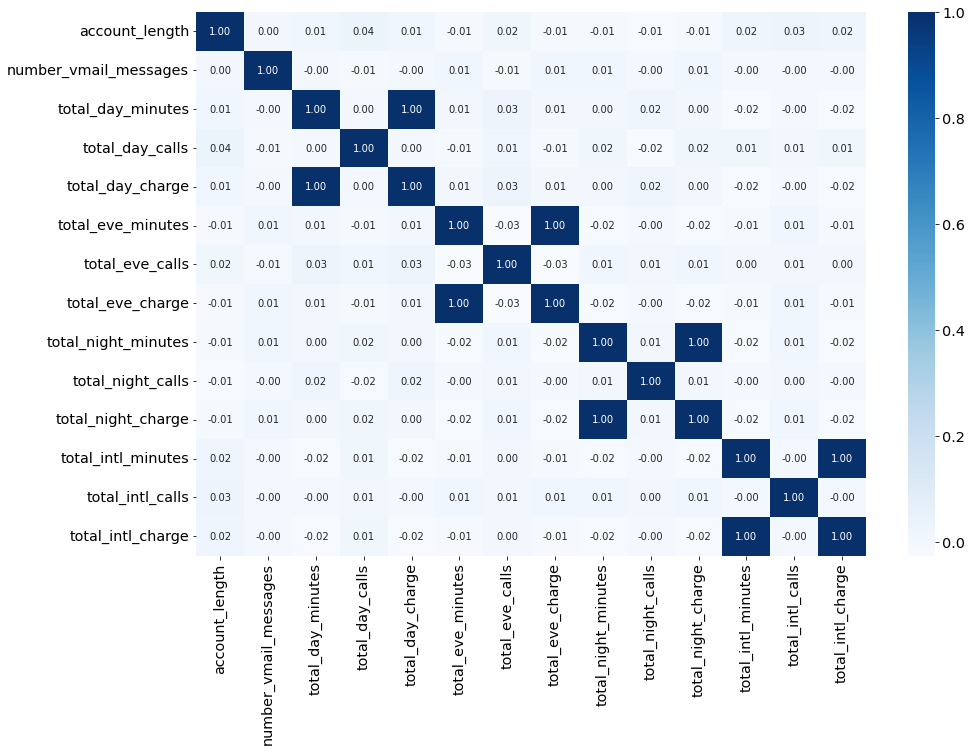

In [21]:
# Heatmap das correlações entre as variáveis numéricas // Heatmap of correlations between numerical variables

num_features_corr =  num_features.remove('number_customer_service_calls')
df_corr = df.corr()
plt.figure(figsize = (15, 10))
sns.heatmap(df_corr, cmap = 'Blues', annot = True, fmt = '.2f');

**Observação:**
Tendo em vista a multicolinearidade entre as variáveis total_day_charge, total_eve_charge, total_night_charge e total_intl_charge com as variáveis total_day_minutes, total_eve_minutes, total_night_minutes e total_intls_minutes, respectivamente (coeficiente de correlação igual a 1), as primeiras serão excluídas do conjunto de dados.

---
_**Observation:**_
_Considering the multicollinearity between the variables total_day_charge, total_eve_charge, total_night_charge and total_intl_charge with the variables total_day_minutes, total_eve_minutes, total_night_minutes and total_intls_minutes, respectively (correlation coefficient equal to 1), the former will be excluded from the data set._


In [22]:
# Remoção de variáveis devido à presença de multicolinearidade
# Removal of variables due to the presence of multicollinearity

df = df.drop(columns = ['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'])

In [23]:
df.dtypes

state                    category
account_length            float64
area_code                category
international_plan       category
voice_mail_plan          category
number_vmail_messages     float64
total_day_minutes         float64
total_day_calls           float64
total_eve_minutes         float64
total_eve_calls           float64
total_night_minutes       float64
total_night_calls         float64
total_intl_minutes        float64
total_intl_calls          float64
churn                    category
dtype: object

In [24]:
# Resumo estatístico das variáveis numéricas restantes // Statistical summary of remaining numeric variables
df.describe()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls
count,3169.000000,3169.000000,3169.000000,3169.00000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000,3169.000000
mean,100.856737,7.974440,180.280120,100.60650,201.086904,100.195014,200.924361,100.023982,10.309340,4.367939
std,39.474815,13.586481,53.835965,19.72475,50.080338,19.614413,49.990627,19.405317,2.665854,2.156224
min,1.000000,0.000000,17.600000,42.00000,49.200000,42.000000,50.100000,42.000000,2.000000,1.000000
25%,74.000000,0.000000,144.000000,87.00000,166.800000,87.000000,167.000000,87.000000,8.500000,3.000000
50%,100.000000,0.000000,179.900000,101.00000,201.400000,100.000000,201.100000,100.000000,10.300000,4.000000
75%,127.000000,19.000000,217.000000,114.00000,235.100000,114.000000,235.600000,113.000000,12.100000,6.000000
max,217.000000,49.000000,337.400000,160.00000,351.600000,159.000000,352.500000,158.000000,18.400000,11.000000


No intuito de obter um modelo preditivo com maior capacidade de generalização, as variáveis account_length e voice_mail_plan serão binarizadas.

---
_In order to obtain a predictive model with greater generalization capacity, the variables account_length e voice_mail_plan will be binarized._


In [25]:
# Binarização das variáveis account_length e voice_mail_plan com base na média
# Binarization of account_length and voice_mail_plan variables based on average

df['account_length'] = np.where(df['account_length'] >= 100.86, 'Igual ou superior à média', 'Inferior à média')
df['number_vmail_messages'] = np.where(df['number_vmail_messages'] >= 7.97, 'Igual ou superior à média','Inferior à média')
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,KS,Igual ou superior à média,area_code_415,no,yes,Igual ou superior à média,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,no
2,OH,Igual ou superior à média,area_code_415,no,yes,Igual ou superior à média,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,no
3,NJ,Igual ou superior à média,area_code_415,no,no,Inferior à média,243.4,114.0,121.2,110.0,162.6,104.0,12.2,5.0,no
4,OH,Inferior à média,area_code_408,yes,no,Inferior à média,299.4,71.0,61.9,88.0,196.9,89.0,6.6,7.0,no
5,OK,Inferior à média,area_code_415,yes,no,Inferior à média,166.7,113.0,148.3,122.0,186.9,121.0,10.1,3.0,no


In [26]:
# Discretização das demais variáveis numéricas // Discretization of the numerical variables
df_temp = df.copy()
dic_cut = {} # gravar em disco
cols_discret =  [col for col in df.select_dtypes(include=['int','float64']).columns if col.startswith('total')]
for col in cols_discret:
    df_temp[col], cut_bin = pd.cut(df_temp[col], bins=5, retbins=True, duplicates='drop',labels=['1','2','3','4','5'])
    dic_cut[col] = cut_bin

print(cols_discret)
df_temp.head()

['total_day_minutes', 'total_day_calls', 'total_eve_minutes', 'total_eve_calls', 'total_night_minutes', 'total_night_calls', 'total_intl_minutes', 'total_intl_calls']


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,KS,Igual ou superior à média,area_code_415,no,yes,Igual ou superior à média,4,3,3,3,4,3,3,1,no
2,OH,Igual ou superior à média,area_code_415,no,yes,Igual ou superior à média,3,4,3,3,4,3,4,1,no
3,NJ,Igual ou superior à média,area_code_415,no,no,Inferior à média,4,4,2,3,2,3,4,2,no
4,OH,Inferior à média,area_code_408,yes,no,Inferior à média,5,2,1,2,3,3,2,3,no
5,OK,Inferior à média,area_code_415,yes,no,Inferior à média,3,4,2,4,3,4,3,1,no


In [27]:
dic_cut

{'total_day_minutes': array([ 17.2802,  81.56  , 145.52  , 209.48  , 273.44  , 337.4   ]),
 'total_day_calls': array([ 41.882,  65.6  ,  89.2  , 112.8  , 136.4  , 160.   ]),
 'total_eve_minutes': array([ 48.8976, 109.68  , 170.16  , 230.64  , 291.12  , 351.6   ]),
 'total_eve_calls': array([ 41.883,  65.4  ,  88.8  , 112.2  , 135.6  , 159.   ]),
 'total_night_minutes': array([ 49.7976, 110.58  , 171.06  , 231.54  , 292.02  , 352.5   ]),
 'total_night_calls': array([ 41.884,  65.2  ,  88.4  , 111.6  , 134.8  , 158.   ]),
 'total_intl_minutes': array([ 1.9836,  5.28  ,  8.56  , 11.84  , 15.12  , 18.4   ]),
 'total_intl_calls': array([ 0.99,  3.  ,  5.  ,  7.  ,  9.  , 11.  ])}

> Formatação de variável // _Variable formatting_

In [28]:
# Formatação de feature (para remoção da parte em string dos dados)
# Feature formatting (for removing the string part of the data)

df = df_temp.copy()
df['area_code'] = df['area_code'].apply(lambda x: x[-3:])
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,KS,Igual ou superior à média,415,no,yes,Igual ou superior à média,4,3,3,3,4,3,3,1,no
2,OH,Igual ou superior à média,415,no,yes,Igual ou superior à média,3,4,3,3,4,3,4,1,no
3,NJ,Igual ou superior à média,415,no,no,Inferior à média,4,4,2,3,2,3,4,2,no
4,OH,Inferior à média,408,yes,no,Inferior à média,5,2,1,2,3,3,2,3,no
5,OK,Inferior à média,415,yes,no,Inferior à média,3,4,2,4,3,4,3,1,no


In [29]:
# Gravação dos dados transformados em disco // Writing the transformed data to disk
df.to_csv('../datasets/df_eng.csv')

### DATASET DE TESTE | _TEST DATA SET_

In [30]:
# Carrega os dados // Load the data
df_test = pd.read_csv('../datasets/projeto4_telecom_teste.csv', index_col = 0)

print(df_test.shape)
display(df_test.head())

(1667, 20)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
1,HI,101,area_code_510,no,no,0,70.9,123,12.05,211.9,73,18.01,236.0,73,10.62,10.6,3,2.86,3,no
2,MT,137,area_code_510,no,no,0,223.6,86,38.01,244.8,139,20.81,94.2,81,4.24,9.5,7,2.57,0,no
3,OH,103,area_code_408,no,yes,29,294.7,95,50.10,237.3,105,20.17,300.3,127,13.51,13.7,6,3.70,1,no
4,NM,99,area_code_415,no,no,0,216.8,123,36.86,126.4,88,10.74,220.6,82,9.93,15.7,2,4.24,1,no
5,SC,108,area_code_415,no,no,0,197.4,78,33.56,124.0,101,10.54,204.5,107,9.20,7.7,4,2.08,2,no


In [31]:
df_test.isnull().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [32]:
# Aplicação das transformações efetuadas nos dados de treino nos dados de teste
# Applying the transformations performed on the training data to the test data

df_test = df_test.drop(columns = ['number_customer_service_calls'])
df_test = df_test.drop(columns = ['total_day_charge','total_eve_charge','total_night_charge','total_intl_charge'])
df_test['area_code'] = df_test['area_code'].apply(lambda x: x[-3:])

# Binarização das variáveis account_length e voice_mail_plan com base na média
df_test['account_length'] = np.where(df_test['account_length'] >= 100.86, 'Igual ou superior à média', 'Inferior à média')
df_test['number_vmail_messages'] = np.where(df_test['number_vmail_messages'] >= 7.97, 'Igual ou superior à média','Inferior à média')

# Discretização de variáveis numéricas
cols_discret =  [col for col in df_test.select_dtypes(include=['int','float64']).columns if col.startswith('total')]
for col in cols_discret:
    df_test[col] = pd.cut(df_test[col], bins=dic_cut[col], include_lowest=True, labels=['1','2','3','4','5'])

df_test.head()


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,HI,Igual ou superior à média,510,no,no,Inferior à média,1,4,3,2,4,2,3,1,no
2,MT,Igual ou superior à média,510,no,no,Inferior à média,4,2,4,5,1,2,3,3,no
3,OH,Igual ou superior à média,408,no,yes,Igual ou superior à média,5,3,4,3,5,4,4,3,no
4,NM,Inferior à média,415,no,no,Inferior à média,4,4,2,2,3,2,5,1,no
5,SC,Igual ou superior à média,415,no,no,Inferior à média,3,2,2,3,3,3,2,2,no


In [33]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1667 entries, 1 to 1667
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   state                  1667 non-null   object  
 1   account_length         1667 non-null   object  
 2   area_code              1667 non-null   object  
 3   international_plan     1667 non-null   object  
 4   voice_mail_plan        1667 non-null   object  
 5   number_vmail_messages  1667 non-null   object  
 6   total_day_minutes      1663 non-null   category
 7   total_day_calls        1664 non-null   category
 8   total_eve_minutes      1660 non-null   category
 9   total_eve_calls        1665 non-null   category
 10  total_night_minutes    1662 non-null   category
 11  total_night_calls      1655 non-null   category
 12  total_intl_minutes     1652 non-null   category
 13  total_intl_calls       1638 non-null   category
 14  churn                  1667 non-null   o

In [34]:
# Checando a presença de valores faltantes após a discretização das variáveis
# Checking the presence of missing values after discretization of variables

df_test.isnull().sum()

state                     0
account_length            0
area_code                 0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         4
total_day_calls           3
total_eve_minutes         7
total_eve_calls           2
total_night_minutes       5
total_night_calls        12
total_intl_minutes       15
total_intl_calls         29
churn                     0
dtype: int64

In [35]:
# Apuração da faixa com maior incidência para as variáveis iniciadas com total
# Calculation of the range with the highest incidence for variables starting with total

cols_discret =  [col for col in df_test.columns if col.startswith('total')]
for col in cols_discret:
    print(df[col].value_counts())

3    1407
4     807
2     718
5     135
1     102
Name: total_day_minutes, dtype: int64
3    1391
2     787
4     748
1     125
5     118
Name: total_day_calls, dtype: int64
3    1400
2     791
4     763
5     113
1     102
Name: total_eve_minutes, dtype: int64
3    1431
2     752
4     729
1     133
5     124
Name: total_eve_calls, dtype: int64
3    1412
2     777
4     763
1     115
5     102
Name: total_night_minutes, dtype: int64
3    1392
4     780
2     755
1     126
5     116
Name: total_night_calls, dtype: int64
3    1491
4     774
2     701
5     107
1      96
Name: total_intl_minutes, dtype: int64
1    1275
2    1059
3     540
4     218
5      77
Name: total_intl_calls, dtype: int64


**Observação:** 
Os valores faltantes gerados com a discretização das variáveis será substituído por 3, que é a faixa com maior incidência.
---

**_Observation:_** 
_The missing values ​​generated with the discretization of variables will be replaced by 3, which is the range with the highest incidence._

In [36]:
# Substituição de nan por 3 ou 1, conforme a maior incidência

cols_discret =  [col for col in df_test.columns if col.startswith('total')]
for col in cols_discret:
    df_test[col] = df_test[col].astype(float)

df_test['total_day_minutes'] = df_test['total_day_minutes'].fillna(3)
df_test['total_day_calls'] = df_test['total_day_calls'].fillna(3)
df_test['total_eve_minutes'] = df_test['total_eve_minutes'].fillna(3)
df_test['total_eve_calls'] = df_test['total_eve_calls'].fillna(3)
df_test['total_night_minutes'] = df_test['total_night_minutes'].fillna(3)
df_test['total_night_calls'] = df_test['total_night_calls'].fillna(3)
df_test['total_intl_minutes'] = df_test['total_night_calls'].fillna(3)
df_test['total_intl_calls'] = df_test['total_intl_calls'].fillna(1)

for col in cols_discret:
    df_test[col] = df_test[col].astype(int)

df_test.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_eve_minutes,total_eve_calls,total_night_minutes,total_night_calls,total_intl_minutes,total_intl_calls,churn
1,HI,Igual ou superior à média,510,no,no,Inferior à média,1,4,3,2,4,2,2,1,no
2,MT,Igual ou superior à média,510,no,no,Inferior à média,4,2,4,5,1,2,2,3,no
3,OH,Igual ou superior à média,408,no,yes,Igual ou superior à média,5,3,4,3,5,4,4,3,no
4,NM,Inferior à média,415,no,no,Inferior à média,4,4,2,2,3,2,2,1,no
5,SC,Igual ou superior à média,415,no,no,Inferior à média,3,2,2,3,3,3,3,2,no


In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1667 entries, 1 to 1667
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   state                  1667 non-null   object
 1   account_length         1667 non-null   object
 2   area_code              1667 non-null   object
 3   international_plan     1667 non-null   object
 4   voice_mail_plan        1667 non-null   object
 5   number_vmail_messages  1667 non-null   object
 6   total_day_minutes      1667 non-null   int32 
 7   total_day_calls        1667 non-null   int32 
 8   total_eve_minutes      1667 non-null   int32 
 9   total_eve_calls        1667 non-null   int32 
 10  total_night_minutes    1667 non-null   int32 
 11  total_night_calls      1667 non-null   int32 
 12  total_intl_minutes     1667 non-null   int32 
 13  total_intl_calls       1667 non-null   int32 
 14  churn                  1667 non-null   object
dtypes: int32(8), object(7

In [ ]:
# Gravação dos dados transformados em disco // Writing the transformed data to disk

df_test.to_csv('../datasets/df_test_eng.csv')

with open(f'../datasets/dic_cut.pkl', 'wb') as pickle_file:
    joblib.dump(dic_cut, pickle_file)